In [1]:
from spectral_cube import SpectralCube
from pvextractor import extract_pv_slice, Path
import pylab as pl
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.visualization.stretch import SinhStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from astropy.utils import data
#from cycler import cycler
#from itertools import cycle
from scipy.stats import ks_2samp
from scipy.optimize import fsolve
from spectral_cube import Projection
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from scipy.interpolate import interp1d

fatal: detected dubious ownership in repository at '/blue/adamginsburg/adamginsburg/repos/dask'
To add an exception for this directory, call:

	git config --global --add safe.directory /blue/adamginsburg/adamginsburg/repos/dask


In [2]:
tau_cube_25 = SpectralCube.read('/orange/adamginsburg/cmz/g5/code/plots/tau_cube_40.fits')

In [3]:
#.with_spectral_unit(u.km/u.second, velocity_convention='radio')

a_fixednames =['/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.12CO.spw17.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.Ha.spw19.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.CH3OH.spw21.fits',
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw23.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.H2CO.spw25.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.SiO.spw27.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.13CO.spw29.fits', 
               '/home/savannahgramze/orange_link/adamginsburg/cmz/g5/G5/a/TP/2018.1.00862.S/galreprojected/g5a.C18O.spw31.fits' 
               ]
cube_17 = SpectralCube.read(a_fixednames[0]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_21 = SpectralCube.read(a_fixednames[2]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_23 = SpectralCube.read(a_fixednames[3]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_25 = SpectralCube.read(a_fixednames[4]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
#cube_27 = SpectralCube.read(a_fixednames[5]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_29 = SpectralCube.read(a_fixednames[6]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')
cube_31 = SpectralCube.read(a_fixednames[7]).with_spectral_unit(u.km/u.s, velocity_convention='radio')#.with_spectral_unit(u.GHz, velocity_convention='radio')

In [4]:
cube_17_reproj = cube_17.reproject(cube_29.header)

In [5]:
def plot_pv(t_pv):
    fig = plt.figure(figsize=(6,6))
    ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
    im = ax.imshow(t_pv.data)
    ax0 = ax.coords[0]
    ax0.set_format_unit(u.arcmin)
    ax1 = ax.coords[1]
    ax1.set_format_unit(u.km/u.s)
    ax.set_ylabel("Velocity [km/s]")
    #ax.set_xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
    ax.set_xlabel("Offset in Longtitude from $\ell=5.48^{\circ}$ [arcmin]")
    ax.set_aspect(0.31)
    cb = pl.colorbar(mappable=im)
    ax.set_ylim(top=t_pv.data.shape[0], bottom=0)

In [6]:
def cross_product(xA, yA, x1, y1, x2, y2): 
    v1 = (x2-x1, y2-y1)   # Vector 1
    v2 = (x2-xA, y2-yA)   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
    above = False
    if xp < 0:
        above = True
        #print('on one side')
    return above
def get_y(x, p1x, p1y, p2x, p2y):
    return (p1y - p2y)/(p1x - p2x)*x + p1y - p1x*(p1y - p2y)/(p1x - p2x)

In [46]:
mas_17 = cube_17_reproj > 0.05 * u.K
mas_29 = cube_29 > 0.05 * u.K

In [47]:
ratio_1729 = cube_17_reproj.with_mask(mas_17).with_mask(mas_29) / cube_29.with_mask(mas_29)

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: Mean of empty slice
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to  2.290e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.252e+01 [aplpy.core]


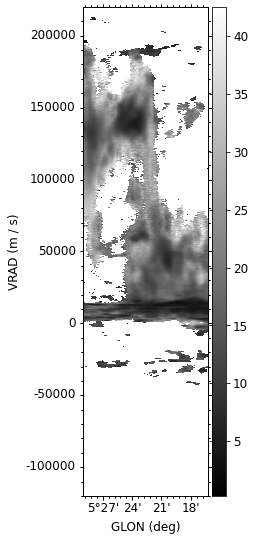

In [48]:
mas_1729 = ratio_1729 < 40
ratio_1729.with_mask(mas_1729).mean(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.481e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.874e+01 [aplpy.core]


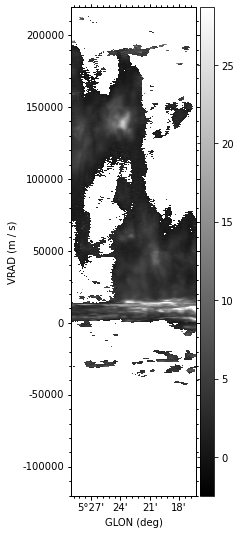

In [10]:
#tau_cube_25[tau_cube_25==0] = np.nan
mas = tau_cube_25!=0 or tau_cube_25 < 30
#mas2 = tau_cube_25 < 30
tau_cube_25.with_mask(mas).max(axis=1).quicklook()

In [11]:
t_pv = tau_cube_25.with_mask(mas).max(axis=1)
t_pv[t_pv>30] = 0

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


In [12]:
x = np.arange(t_pv.data.shape[1])
y1 = get_y(x, 0, 410, 5, 410)
y2 = get_y(x, 0, 600, 50, 650)
y3 = get_y(x, 80, 400, 80.001, 500)
y4 = get_y(x, 0, 600, 5, 600)
y5 = get_y(x, 170, 600, 150, 750)
y6 = get_y(x, 125, 600, 120, 750)

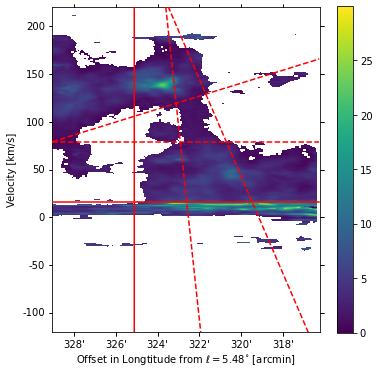

In [13]:
plot_pv(t_pv)
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='red', linestyle='dashed')
plt.plot(x, y3, color='red')
plt.plot(x, y4, color='red', linestyle='dashed')
plt.plot(x, y5, color='red', linestyle='dashed')
plt.plot(x, y6, color='red', linestyle='dashed')
#plt.scatter(125, 600, color='magenta')
#plt.scatter(120, 750, color='magenta')

In [14]:
tau_cube_25.spectral_axis[410].to(u.km/u.second)

<Quantity 16.127296 km / s>

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.061e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.494e+01 [aplpy.core]


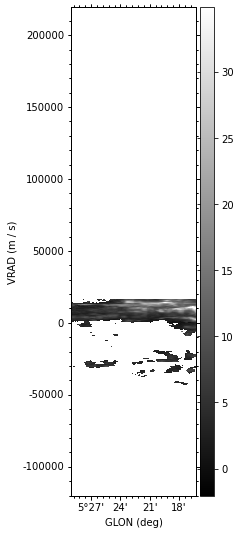

In [15]:
mask_sightline = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 410, 5, 410)
        #check2 = cross_product(xA, yA, 85, 460, 75, 700)
        #check3 = cross_product(xA, yA, 75, 700, 40, 600)
        #check4 = cross_product(xA, yA, 40, 600, 55, 350)
        mask_sightline[yA, xA] = not check1# and check2 and check3 and check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
tau_cube_25.with_mask(mas).with_mask(mask_sightline[:, None, :]).max(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -8.242e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.126e+01 [aplpy.core]


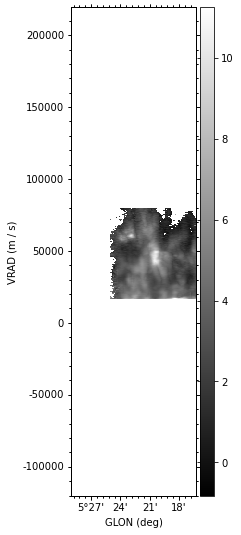

In [16]:
mask_G5b = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 410, 5, 410)
        check2 = cross_product(xA, yA, 0, 600, 5, 600)
        check3 = cross_product(xA, yA, 80, 400, 80.001, 500)
        #check4 = cross_product(xA, yA, 40, 600, 55, 350)
        mask_G5b[yA, xA] = check1 and not check2 and not check3 #and check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
tau_cube_25.with_mask(mas).with_mask(mask_G5b[:, None, :]).max(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.003e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.301e+01 [aplpy.core]


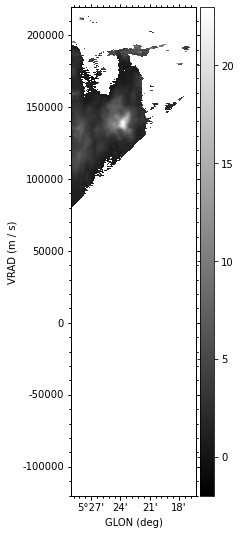

In [17]:
mask_G5a = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 600, 50, 650)
        #check2 = cross_product(xA, yA, 85, 460, 75, 700)
        #check3 = cross_product(xA, yA, 75, 700, 40, 600)
        #check4 = cross_product(xA, yA, 40, 600, 55, 350)
        mask_G5a[yA, xA] = check1# and check2 and check3 and check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
tau_cube_25.with_mask(mas).with_mask(mask_G5a[:, None, :]).max(axis=1).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.080e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.425e+00 [aplpy.core]


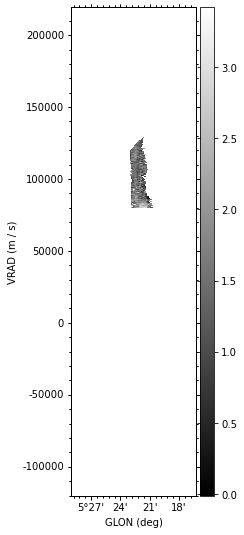

In [18]:
mask_bridge = np.copy(t_pv.mask.include())
for yA in range(mask_sightline.shape[0]):
    for xA in range(mask_sightline.shape[1]):
        check1 = cross_product(xA, yA, 0, 600, 50, 650)
        check2 = cross_product(xA, yA, 0, 600, 5, 600)
        check3 = cross_product(xA, yA, 170, 600, 150, 750)
        check4 = cross_product(xA, yA, 125, 600, 120, 750)
        mask_bridge[yA, xA] = not check1 and check2 and check3 and not check4
#fig = plt.figure(figsize=(6,6))
#ax = pl.subplot(111, projection=wcs.WCS(t_pv.header))
#plt.imshow(mask_sightline)
tau_cube_25.with_mask(mas).with_mask(mask_bridge[:, None, :]).max(axis=1).quicklook()

In [49]:
arr_bridge = np.array(tau_cube_25.with_mask(mask_bridge[:, None, :]).with_mask(mas_29).flattened())
arr_G5a = np.array(tau_cube_25.with_mask(mask_G5a[:, None, :]).with_mask(mas_29).flattened())
arr_G5b = np.array(tau_cube_25.with_mask(mask_G5b[:, None, :]).with_mask(mas_29).flattened())
arr_sightline = np.array(tau_cube_25.with_mask(mask_sightline[:, None, :]).with_mask(mas_29).flattened())

arr_bridge[arr_bridge==0] = np.nan
arr_G5a[arr_G5a==0] = np.nan
arr_G5b[arr_G5b==0] = np.nan
arr_sightline[arr_sightline==0] = np.nan

bins = np.geomspace(0.05, 10, num=20)#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        
#plt.hist(arr_bridge[np.isfinite(arr_bridge)], density=True)
counts_bridge, bins_bridge = np.histogram(arr_bridge[np.isfinite(arr_bridge)], bins=bins)
counts_G5a, bins_G5a = np.histogram(arr_G5a[np.isfinite(arr_G5a)], bins=bins)
counts_G5b, bins_G5b = np.histogram(arr_G5b[np.isfinite(arr_G5b)], bins=bins)
counts_sightline, bins_sightline = np.histogram(arr_sightline[np.isfinite(arr_sightline)], bins=bins)

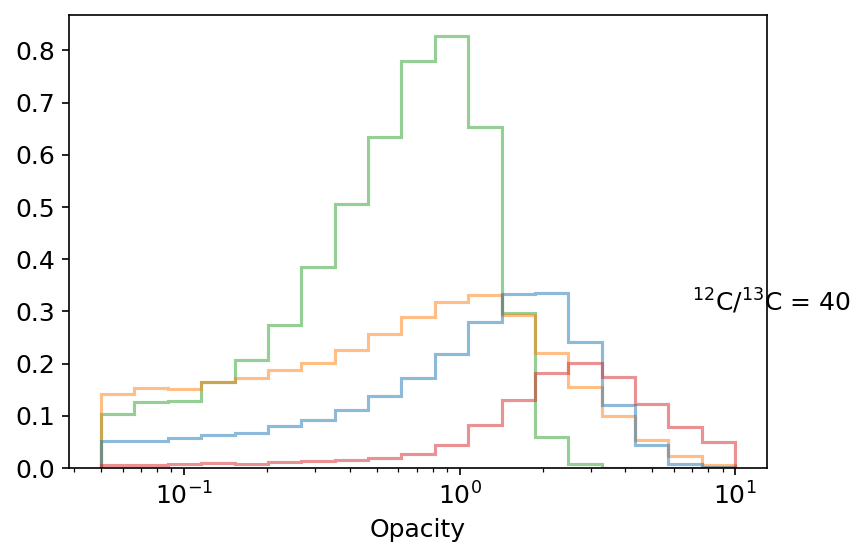

In [54]:
plt.figure(figsize=(6,4),dpi=150)
plt.rcParams.update({'font.size': 12})
plt.hist(bins_bridge[:-1], bins_bridge, alpha=0.5, label='Velocity Bridge', color='tab:green', weights=counts_bridge, density=True, histtype='step', linewidth=1.5)
plt.hist(bins_G5a[:-1], bins_G5a, alpha=0.5, label='High Velocity Cloud G5a', color='tab:orange', weights=counts_G5a, density=True, histtype='step', linewidth=1.5)
plt.hist(bins_G5b[:-1], bins_G5b, alpha=0.5, label='Low Velocity Cloud G5b', color='tab:blue', weights=counts_G5b, density=True, histtype='step', linewidth=1.5)
plt.hist(bins_sightline[:-1], bins_sightline, alpha=0.5, label='Line of Sight Sight Clouds', color='tab:red', weights=counts_sightline, density=True, histtype='step', linewidth=1.5)
plt.xlabel('Opacity')
plt.text(7, 0.3, '$^{12}$C/$^{13}$C = 40')

#plt.legend()
plt.xscale('log')
#plt.savefig('/orange/adamginsburg/cmz/g5/code/plots/opacity_hist_40.pdf',bbox_inches='tight')

In [51]:
#cube_17.max()#/(0.05*u.K)
50/0.05

1000.0

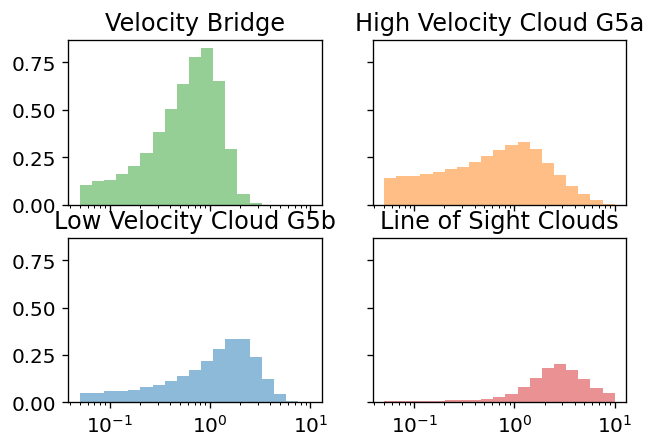

In [53]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_dpi(120)
axs[0, 0].hist(bins_bridge[:-1], bins_bridge, alpha=0.5, label='Velocity Bridge', color='tab:green', weights=counts_bridge, density=True)
axs[0, 0].set_title('Velocity Bridge')
axs[0, 1].hist(bins_G5a[:-1], bins_G5a, alpha=0.5, label='High Velocity', color='tab:orange', weights=counts_G5a, density=True)
axs[0, 1].set_title('High Velocity Cloud G5a')
axs[1, 0].hist(bins_G5b[:-1], bins_G5b, alpha=0.5, label='Low Velocity', color='tab:blue', weights=counts_G5b, density=True)
axs[1, 0].set_title('Low Velocity Cloud G5b')
axs[1, 1].hist(bins_sightline[:-1], bins_sightline, alpha=0.5, label='Sight Clouds', color='tab:red', weights=counts_sightline, density=True)
axs[1, 1].set_title('Line of Sight Clouds')
#for ax_x in axs:
#        for axi in ax_x:
#            axi.legend()
#plt.xlim(left=-0.1, right=10)
for ax in axs.flat:
    ax.label_outer()
    ax.set_xscale('log')
print()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -3.490e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.874e+00 [aplpy.core]


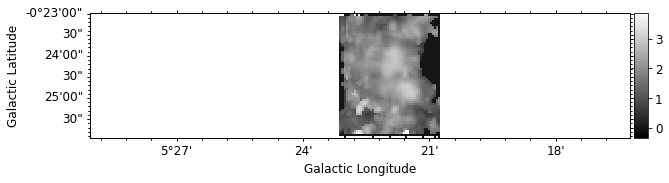

In [23]:
tau_cube_25.with_mask(mask_bridge[:, None, :]).max(axis=0).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -2.439e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.707e+01 [aplpy.core]


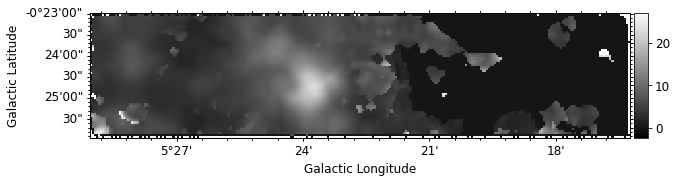

In [24]:
tau_cube_25.with_mask(mask_G5a[:, None, :]).max(axis=0).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -1.173e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.303e+01 [aplpy.core]


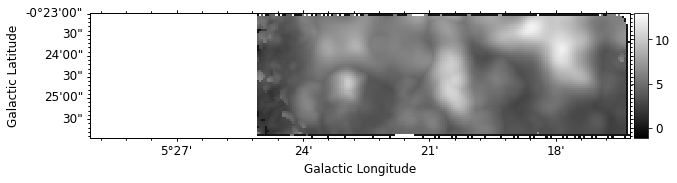

In [25]:
tau_cube_25.with_mask(mask_G5b[:, None, :]).max(axis=0).quicklook()

/blue/adamginsburg/adamginsburg/repos/spectral-cube/spectral_cube/spectral_cube.py:439: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


INFO: Auto-setting vmin to -3.421e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.798e+01 [aplpy.core]


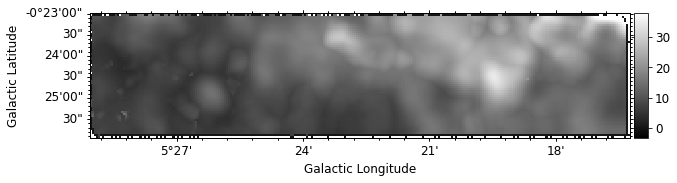

In [26]:
tau_cube_25.with_mask(mask_sightline[:, None, :]).max(axis=0).quicklook()

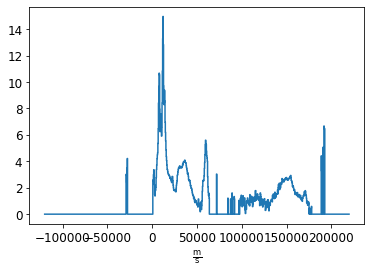

In [27]:
tau_cube_25[:, 30, 131].quicklook()

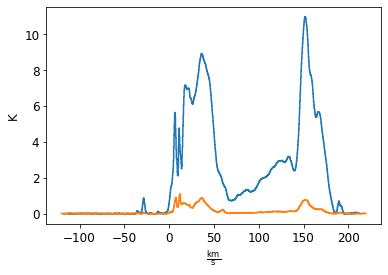

In [28]:
(cube_17_reproj[:, 30, 131]).quicklook()
cube_29[:, 30, 131].quicklook()

In [29]:
teng_outer_Alphaco = 0.5 * u.Msun / (u.K * u.km / u.second * u.pc**2)
teng_outer_Alphaco

<Quantity 0.5 s solMass / (K km pc2)>

In [30]:
teng_avg_Alphaco = 1.5 * u.Msun / (u.K * u.km / u.second * u.pc**2)
teng_avg_Alphaco

<Quantity 1.5 s solMass / (K km pc2)>

In [31]:
teng_center_Alphaco = 2.0 * u.Msun / (u.K * u.km / u.second * u.pc**2)
teng_center_Alphaco

<Quantity 2. s solMass / (K km pc2)>

In [32]:
# 0.1 M ⊙ (K km s-1 pc2)-1, Teng et al 
teng_Alphaco = 0.12 * u.Msun / (u.K * u.km / u.second * u.pc**2) 
teng_Alphaco

<Quantity 0.12 s solMass / (K km pc2)>

In [33]:
gal_Alphaco = 4.4 * u.Msun / (u.K * u.km / u.second * u.pc**2) 
gal_Alphaco

<Quantity 4.4 s solMass / (K km pc2)>

In [34]:
gal_Xco = 2.3e20 *u.cm**-2 * (u.K * u.km / u.second)**-1 
gal_Xco

<Quantity 2.3e+20 s / (cm2 K km)>

In [35]:
teng_Alphaco / gal_Alphaco * gal_Xco / 10**20

<Quantity 0.06272727 s / (cm2 K km)>

In [36]:
teng_center_Alphaco / gal_Alphaco * gal_Xco

<Quantity 1.04545455e+20 s / (cm2 K km)>

In [37]:
teng_outer_Alphaco.to(u.Da * u.cm**-2 * (u.K * u.km / u.second)**(-1)) / (2.016*u.Da) /10**20

<Quantity 0.31191424 s / (cm2 K km)>

In [38]:
teng_avg_Alphaco.to(u.Da * u.cm**-2 * (u.K * u.km / u.second)**(-1)) / (2.016*u.Da)/10**20

<Quantity 0.93574271 s / (cm2 K km)>

In [39]:
teng_center_Alphaco.to(u.Da * u.cm**-2 * (u.K * u.km / u.second)**(-1)) / (2.016*u.Da)/10**20

<Quantity 1.24765695 s / (cm2 K km)>

In [40]:
teng_Alphaco.to(u.Da * u.cm**-2 * (u.K * u.km / u.second)**(-1)) / (2.016*u.Da)/10**20

<Quantity 0.07485942 s / (cm2 K km)>

In [41]:
mas_29_1 = cube_29 > 5*0.05*u.K
mas_17_1 = cube_17_reproj > 5*0.05*u.K

In [56]:
cu_29 = (cube_29.with_mask(mas_29_1).with_mask(mas_17_1)).flattened()
#cu_29 = (cube_29.with_mask(mask_bridge[:, None, :])).flattened()

In [57]:
cu_17 = (cube_17_reproj.with_mask(mas_17_1).with_mask(mas_29_1)).flattened()
#cu_17 = (cube_17_reproj.with_mask(mask_bridge[:, None, :])).flattened()

In [58]:
def y(x):
    return 1/40*x
x = np.linspace(0, 16, num=50)
y_rat = y(x)

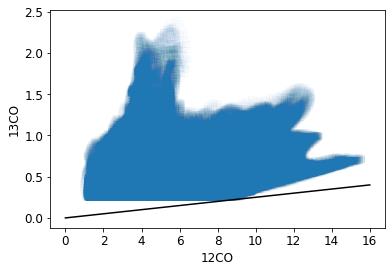

In [60]:
# color code with regions? velocity brigd, G5a, G5b, line of sight
plt.scatter(cu_17, cu_29, marker=',', alpha=0.01)
plt.xlabel('12CO')
plt.ylabel('13CO')
#plt.ylim(0, 0.2)
plt.plot(x, y_rat, color='k')

In [ ]:
(cube_29.with_mask(mas_29_1).with_mask(mas_17_1)).mean(axis=1).quicklook()